# Iteracion 1 de PINN
#### Orden
1. Importacion de bibliotecas
2. Definir parametros del backward facing step
3. Funcion que genera los puntos donde se muestrea el backwards facing step
4. Declaracion y Generación de red Neuronal
5. definición de la función de inlet

#### Problemas actuales
- cambio en esta versión
    - No se usa Jacobiano ni hessiano
- No se deja optimizar
    - depende del calculo de navierstokes en X y en Y. No de la continuidad
        - Incluir la velocidad (producto directo de la red hace que la red falle) 
        - El hessiano funciona tranquilo
        - El Jacobiano Tambien
    - Soluciones posibles
        - usar model.eval()
        - model.train()
        - usar siempre los mismos puntos
        - revisar funciones de puntos
#### To do
- puntear linea
- averiguar como lo hacen deep xde
- intentar implementar hard boundary conditions
- considerar modelo de pared (u+ , y+)
- buscar usar multithreading
- Generar sampleo de puntos con funciones peso dinamico para consumir menos tiempo evaluando

$$f(x,y) = red neuronal$$
$$g(x,y) = (y-limiteY)*f(x)$$

Considerar usar limites duros

### Importación de bibliotecas

In [1]:
import matplotlib.pyplot as plt 
import random as rd
import numpy as np
import torch 
import torch.nn as nn
#torch.autograd.set_detect_anomaly(True)

### Definición de parametros del Backwards Facing step

In [2]:
re=1
rho=1
mu=1
uprom=2
xinf=0
xsup=1
ubicacionSalto=0.2
altoSalto=0
device = "cpu"
dtype = torch.long
def ysup(x):
	return 1
def yinf(x):
	#Esta funcion define el limite inferior de mi fluido en Y como una funcion de x
	if (x>ubicacionSalto):
		return 0
	else:
		return altoSalto

### Definición de la función generadora de puntos

In [3]:
def nube(n_interno,n_frontera):
	#Esta funcion genera los puntos aleatorios sobre los cuales se va a probar la 
	#funcion de perdida
	#n_interno corresponde a los puntos internos del fluido
	#n_frontera corresponde a los puntos sobre los cuales se probara la condicion de frontera
    puntosInternos=[]
    puntosInlet=[]
    puntosPared=[]
    puntosOutlet=[]
    for i in range(n_interno):#Estos son los puntos Internos
        xtemp=xinf+(xsup-xinf)*rd.random()
        ytemp=yinf(xtemp)+(ysup(xtemp)-yinf(xtemp))*rd.random()
        puntosInternos.append([xtemp,ytemp])

	#Estos puntos estan en las fronteras
    for i in range(n_frontera):
        seleccion = rd.randint(1,5)
        if(seleccion == 1): #Esta va a ser la frontera de la pared arriba
            xtemp=xinf+(xsup-xinf)*rd.random()
            ytemp=ysup(xtemp)
            puntosPared.append([xtemp,ytemp])
        elif (seleccion == 2): #Esta va a ser la pared de abajo sin incluir el step
            xtemp=xinf+(xsup-xinf)*rd.random()
            ytemp=yinf(xtemp)
            puntosPared.append([xtemp,ytemp])
        elif (seleccion==3): #Esta va a ser la pared donde hay el backwards facing step
            xtemp=ubicacionSalto
            ytemp=yinf(xsup)+altoSalto*rd.random()
            puntosPared.append([xtemp,ytemp])
        elif (seleccion==4): #Este va a ser el inlet
            xtemp=xinf
            ytemp=yinf(xtemp)+(ysup(xtemp)-yinf(xtemp))*rd.random()
            puntosInlet.append([xtemp,ytemp])
        else:
            xtemp=xsup
            ytemp=yinf(xtemp)+(ysup(xtemp)-yinf(xtemp))*rd.random()
            puntosOutlet.append([xtemp,ytemp])

    puntosInternos = torch.Tensor(puntosInternos)
    puntosPared = torch.Tensor(puntosPared)
    puntosInlet = torch.Tensor(puntosInlet)
    puntosOutlet = torch.Tensor(puntosOutlet)



    return ([puntosInternos,puntosPared,puntosInlet,puntosOutlet])

def plottearNube(n_interno,n_frontera):
    # Esta función plottea n_interno puntos internos y n_frontera puntos en la frontera 
	labels=["Fluido","Pared","Inlet","Outlet"]
	y=0
	for j in nube(n_interno,n_frontera):
		xtemp=[]
		ytemp=[]
		for i in j:
			xtemp.append(i[0])
			ytemp.append(i[1])
		plt.plot(xtemp,ytemp,linewidth=0,marker="o",label=labels[y])
		y+=1
	plt.legend()
	plt.show()

### Definición y generación de la red neuronal

In [4]:
import torch.nn as nn
class NeuralNetworkPrueba(nn.Module):
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


red=NeuralNetworkPrueba().to(device)

### Definición de la función de inlet

In [5]:
class u_ini_clase(torch.autograd.Function):
	#Esta clase corresponde al perfil de entrada
	@staticmethod
	def forward(ctx, input):
		ctx.save_for_backward(input)
		k=-8*uprom/(ysup(xinf)-yinf(xinf))**2
		return k * (input-yinf(xinf))*(input-ysup(xinf))
	
	@staticmethod
	def backward(ctx, grad_output):
		input, = ctx.saved_tensors
		k=-8*uprom/(ysup(xinf)-yinf(xinf))**2
		return grad_output * k * (2 * input - ysup(xinf)+yinf(xinf))
u_ini_2=u_ini_clase.apply

In [6]:
i = torch.linspace(0,1,2)
i.requires_grad = True
u_i = red(i)[0]
dudx_prueba = torch.autograd.grad(u_i,i,create_graph=True)[0]
print(dudx_prueba[0])

tensor(0.0148, grad_fn=<SelectBackward>)


### Definición de la función de perdida

$$\text{jacobiano}=\begin{pmatrix}
\frac{du}{dx} & \frac{du}{dy} \\
\frac{dv}{dx} & \frac{dv}{dy}
\end{pmatrix}$$

$$\text{hessiano}_u=\begin{pmatrix}
\frac{d^2u}{dx^2} & \frac{d^2u}{dxdy} \\
\frac{d^2u}{dxdy} & \frac{d^2u}{dy^2}
\end{pmatrix}$$

$$\text{hessiano}_v=\begin{pmatrix}
\frac{d^2v}{dx^2} & \frac{d^2v}{dxdy} \\
\frac{d^2v}{dxdy} & \frac{d^2v}{dy^2}
\end{pmatrix}$$

In [6]:
k_inlet = 1
k_outlet = 1
k_pared = 1
k_continuidad = 1

registro_perdida_interna=[]
registro_perdida_pared=[]
registro_perdida_inlet=[]
registro_perdida_outet=[]


def miniPerdidaInlet(puntos_inlet):
	# Esta es una función auxiliar que calcula la perdida sobre el inlet 
	sumaInterna = 0
	for i in puntos_inlet:
		sumaInterna+=red(i)[1]**2
		sumaInterna+=(red(i)[0]-u_ini_2(i[1]))**2
	print("funciono un inlet")
	return sumaInterna
	
def miniPerdidaPared(puntos_pared):
	# Esta es una funcíón auxiliar que calcula la perdida sobre la pared
	sumaInterna = 0
	for i in puntos_pared:
		sumaInterna+=torch.abs(red(i)[0])
		sumaInterna+=torch.abs(red(i)[1])
	print("funciono una pared")
	return sumaInterna
		
def miniPerdidaOutlet(puntos_outlet):
	# Esta es una funcíón auxiliar que calcula la perdida sobre la pared
	sumaInterna = 0
	for i in puntos_outlet:
		sumaInterna+=torch.abs(p(i))
	print("funciono un outlet")
	return sumaInterna	

def u(x):
	return red(x)[0]

def v(x):
	return red(x)[1]

def p(x):
	return red(x)[2]

def miniperdidaInterna(puntos_internos):
	# Esta es una funcíón auxiliar que calcula la perdida sobre el fluido con Navier Stokes y condición de continuidad
	global k_continuidad
	suma=0
	suma=torch.tensor(0)
	imprime = False
	for i in puntos_internos:
		i.requires_grad = True
		u_i=red(i)[0] #Esta variable existe para consumir ram pero cpu tiempo computacional 
		v_i=red(i)[1] #Esta variable existe para consumir ram pero cpu tiempo computacional
		p_i=red(i)[2]
		#calculo de las derivadas

		dudx = torch.autograd.grad(u_i,i,create_graph=True,retain_graph = True)[0][0]
		dudy = torch.autograd.grad(u_i,i,create_graph=True,retain_graph = True)[0][1]
		dvdx = torch.autograd.grad(v_i,i,create_graph=True,retain_graph = True)[0][0]
		dvdy = torch.autograd.grad(v_i,i,create_graph=True,retain_graph = True)[0][1]
		dpdx = torch.autograd.grad(p_i,i,create_graph=True,retain_graph = True)[0][0]
		dpdy = torch.autograd.grad(p_i,i,create_graph=True,retain_graph = True)[0][1]
		dduddx = torch.autograd.grad(dudx,i,create_graph=True,retain_graph = True)[0][0]
		dduddy = torch.autograd.grad(dudy,i,create_graph=True,retain_graph = True)[0][1]
		ddvddx = torch.autograd.grad(dvdx,i,create_graph=True,retain_graph = True)[0][0]
		ddvddy = torch.autograd.grad(dvdy,i,create_graph=True,retain_graph = True)[0][1]

		terminoDifusivo_u = dduddx+dduddy
		terminoDifusivo_v = ddvddy+ddvddx

		a_conv_u = dudx*u_i+dudy*v_i #aceleracion convectiva
		a_conv_v = dvdx*u_i+dvdy*v_i #aceleracion convectiva
		
		continuidad = dudx +dvdy
		
		#nsEstaticoX = dpdx+dpdy
		#nsEstaticoY = dpdx+dpdy
		nsEstaticoX=rho*a_conv_u+dpdx-(terminoDifusivo_u)*mu
		nsEstaticoY=rho*a_conv_v+dpdy-(terminoDifusivo_v)*mu
		
		suma.add(nsEstaticoX**2)
		suma.add(nsEstaticoY**2)
		
		suma.add(k_continuidad*continuidad**2)
		if imprime:
			print("Punto Prueba")
			print(i)
			print("Jacobiano")
			print(jacobiano)
			print("Hessiano de u")
			print(hessiano_u)
			#print("Estatico en X",nsEstaticoX)
			print("Estatico en Y",nsEstaticoY)
			print("continuidad",continuidad)
	print("funciono la suma")
	print(suma)
	return suma


puntos = nube(20,200)

def perdida(n_internos,n_frontera):
	global k_pared,k_inlet,k_outlet,k_continuidad
	#puntos = nube(n_internos,n_frontera)
	global puntos
	suma = torch.tensor(0) #la variable suma es la que va a cargar la suma de las perdidas
	
	# Perdida Interna
	calculoStokes=miniperdidaInterna(puntos[0])
	registro_perdida_interna.append(calculoStokes.detach().numpy())
	suma.add(calculoStokes) #ACA DEBE IR LA ECUACION DE NAVIER STOKES Y CONTINUIDAD

	#perdida pared
	calculoPared=miniPerdidaPared(puntos[1])
	registro_perdida_pared.append(calculoPared.detach().numpy())
	suma.add(k_pared*calculoPared) #ACA DEBE IR LA ECUACION DE LA PARED
	
	#perdida inlet
	calculoInlet=miniPerdidaInlet(puntos[2])
	registro_perdida_inlet.append(calculoInlet.detach().numpy())
	suma.add(k_inlet*calculoInlet) #ACA DEBE IR LA CONDICION PARA QUE EL FLUJO ENTRE DESARROLADO
	
	#perdida outlet
	calculoOutlet=miniPerdidaOutlet(puntos[3])
	registro_perdida_outet.append(calculoOutlet.detach().numpy())
	suma.add(k_outlet*calculoOutlet) #ACA DEBE IR LA ECUACION PARA EL OUTLET, ESTA ES DE PRESION UNICAMENTE

	k_pared = calculoStokes/(min(1e-3,calculoPared))
	k_inlet = calculoStokes/(min(1e-3,calculoInlet))
	k_outlet = calculoStokes/(min(1e-3,calculoOutlet))
	k_continuidad = calculoStokes/3
	return suma


def probarPerdida():
	print(perdida(10,100))
	print("interna",registro_perdida_interna)
	print("pared",registro_perdida_pared)
	print("inlet",registro_perdida_inlet)
	print("outlet",registro_perdida_outet)

In [7]:
probarPerdida()

funciono la suma
tensor(0)
funciono una pared
funciono un inlet
funciono un outlet
tensor(0)
interna [array(0, dtype=int64)]
pared [array(18.841955, dtype=float32)]
inlet [array(314.4793, dtype=float32)]
outlet [array(2.5246654, dtype=float32)]


### Aprendizaje de la red

In [11]:
learning_rate = 1e-6
batch_size = 64
epochs = 4

optimizer = torch.optim.Adam(red.parameters(), lr=learning_rate)
registro_perdida=[]
for i in range(epochs):
    print(i)
    # Compute prediction and loss
    loss = perdida(2500,2500)
    # Backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())
    if i % 100 == 0:
        print(loss.item())
    registro_perdida.append(loss.item())

0
funciono la suma
funciono una pared
funciono un inlet
funciono un outlet


RuntimeError: grad can be implicitly created only for scalar outputs

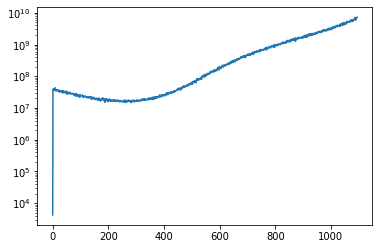

In [9]:
plt.semilogy(registro_perdida[:])

# Pruebas

In [23]:
def perdidaGeneradoraParabolica():
    suma = 0
    for x_temp in torch.linspace(0,1,80):
        for y_temp in torch.linspace(0,1,500):
            x=torch.tensor([x_temp,y_temp])
            suma += (u_ini_2(x[1])-red(x)[0])**2+red(x)[1]**2+red(x)[2]**2
        for y_temp in torch.linspace(0.45,0.65,40):
            x=torch.tensor([x_temp,y_temp])
            suma += (u_ini_2(x[1])-red(x)[0])**2+red(x)[1]**2+red(x)[2]**2
        for y_temp in torch.linspace(0,0.1,30):
            x=torch.tensor([x_temp,y_temp])
            suma += (u_ini_2(x[1])-red(x)[0])**2+red(x)[1]**2+red(x)[2]**2
    return suma
perdidaGeneradoraParabolica()

tensor(417077.5312, grad_fn=<AddBackward0>)

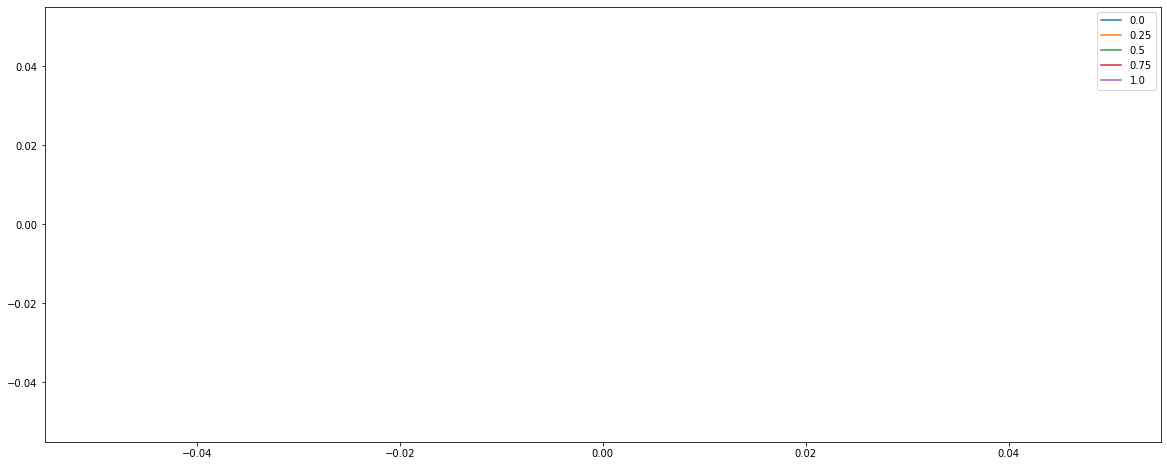

In [14]:
plt.figure(figsize=(20,8))
for x in np.linspace(0,1,5):
    y=np.linspace(0,1,50)
    utemp = []
    for i in y:
        i_temp=torch.tensor([x,i],dtype=torch.float32)
        utemp.append(red(i_temp).detach().numpy()[0])
    plt.plot(utemp,y,label=x)
#plt.plot(u_ini_2(y).detach.numpy(),y,label="ideal")
plt.legend()
plt.show()

In [ ]:
learning_rate = 9e-6
batch_size_interno = 2500
batch_size_frontera = 800
epochs = 200
import time
start = time.time()
optimizer = torch.optim.Adam(red.parameters(), lr=learning_rate)
registro_perdida=[]
for i in range(epochs):
    # Compute prediction and loss
    loss = perdidaGeneradoraParabolica()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(loss.item())
    registro_perdida.append(loss.item())

122.06570434570312
120.52519989013672
119.02569580078125
117.5660400390625
116.14288330078125


### Pruebas a la funcion de perdida
#### Pruebas realizadas
- Probar que la función corra
    - probar que la función calcule gradientes y jacobianos
#### Pruebas pendientes
- Probar con un perfil parabolico
    - Probar que el perfil parabolico retorne el hessiano apropiado
    - Probar que el perfil parabolico retorne el jacobiano apropiado
    - Probar que el perfil parabolico retorne la derivada apropiada

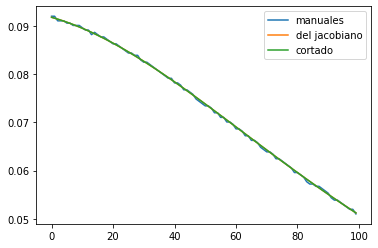

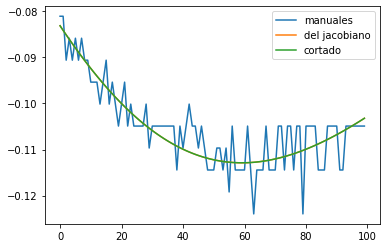

In [ ]:
x_prueba=torch.linspace(0,1,100)
derivadasManuales=[]
derivadasdelJabociano=[]
derivadas3=[]

def u_prueba(x):
    return red(x)[0]

for i in x_prueba: 
    w=torch.tensor([0,i],dtype=torch.float32)
    derivadasdelJabociano.append(torch.autograd.functional.jacobian(red,w)[0,0].detach().numpy())
    dudxprueba=(red(w+torch.Tensor([0.001,0]))-red(w))/0.001
    derivadasManuales.append(dudxprueba[0].detach().numpy())
    dudxprueba2 = derivadas3.append(torch.autograd.functional.jacobian(red,w)[0,0].detach().numpy())


plt.plot(derivadasManuales,label="manuales")
plt.plot(derivadasdelJabociano,label="del jacobiano")
plt.plot(derivadas3,label="cortado")
plt.legend()
plt.show()

derivadasManuales=[]
derivadasdelJabociano=[]
derivadas3=[]

h=1e-2
for i in x_prueba: 
    w=torch.tensor([0,i],dtype=torch.float32)
    derivadasdelJabociano.append(torch.autograd.functional.hessian(u_prueba,w)[0,0].detach().numpy())
    dudxprueba=(red(w+torch.Tensor([h,0]))+red(w-torch.Tensor([h,0]))-2*red(w))/h**2
    derivadasManuales.append(dudxprueba[0].detach().numpy())
    dudxprueba2 = derivadas3.append(torch.autograd.functional.hessian(u_prueba,w)[0,0].detach().numpy())




plt.plot(derivadasManuales,label="manuales")
plt.plot(derivadasdelJabociano,label="del jacobiano")
plt.plot(derivadas3,label="cortado")
plt.legend()
plt.show()


In [ ]:
probarPerdida()
probarPerdida()


funciono la suma
funciono una pared
funciono un inlet
funciono un outlet
tensor(141.1049, grad_fn=<AddBackward0>)
interna [array(0.04695344, dtype=float32)]
pared [array(11.313935, dtype=float32)]
inlet [array(127.71476, dtype=float32)]
outlet [array(2.0292184, dtype=float32)]
funciono la suma
funciono una pared
funciono un inlet
funciono un outlet
tensor(11620.9639, grad_fn=<AddBackward0>)
interna [array(0.04695344, dtype=float32), array(0.03427401, dtype=float32)]
pared [array(11.313935, dtype=float32), array(8.861301, dtype=float32)]
inlet [array(127.71476, dtype=float32), array(236.02429, dtype=float32)]
outlet [array(2.0292184, dtype=float32), array(2.6134412, dtype=float32)]


### Funciones para graficar los flujos

In [ ]:
def sacaVelocidades(x,y):
    x_temp1=torch.tensor([x,y])
    resultado=red(x_temp1).detach().numpy()
    return resultado[0],resultado[1]	
def graficarVelocidades():
	#Esto aun no funciona porque no termino de entender quiver
    flechasEnX=18
    flechasEnY=14
	
    flechasEnPrimeraSeccion=int(flechasEnX*(ubicacionSalto-xinf)/(xsup-xinf))	
    flechasEnSegundaSeccion=flechasEnX-flechasEnPrimeraSeccion
   	
    xtemp=np.linspace(xinf,ubicacionSalto,flechasEnPrimeraSeccion)
    ytemp=np.linspace(yinf(xinf),ysup(xinf),flechasEnY)

    
    Xtemp,Ytemp=np.meshgrid(xtemp,ytemp)
    print(Xtemp)
    print(Ytemp)
    utemp,vtemp=sacaVelocidades(Xtemp,Ytemp)

    
    plt.figure(figsize=(10,10))
    plt.ylim(yinf(xsup),ysup(xsup))
    plt.xlim(xinf,xsup)
    plt.quiver(xtemp,ytemp,utemp,vtemp,units="xy",scale=75,width=0.005)
   	
    xtemp=np.linspace(ubicacionSalto,xsup,flechasEnSegundaSeccion)
    ytemp=np.linspace(yinf(xsup),ysup(xsup),flechasEnY)	
    Xtemp,Ytemp=np.meshgrid(xtemp,ytemp)
    utemp,vtemp=sacaVelocidades(Xtemp,Ytemp)
    plt.quiver(xtemp,ytemp,utemp,vtemp,units="xy",scale=75,width=0.005)

    plt.show()
def trazadorDeStreamLine(x_ini,y_ini):	
	ntemp=50
	deltaTemp=(xsup-x_ini)/ntemp
	xtemp=[x_ini]
	ytemp=[y_ini]
	for i in range(ntemp):
		utemp,vtemp=sacaVelocidades(xtemp[-1],ytemp[-1])
		xtemp.append(xtemp[-1]+utemp*deltaTemp)
		ytemp.append(ytemp[-1]+vtemp*deltaTemp)
	plt.plot(xtemp,ytemp)
	plt.show()